In [1]:
import random
import torch
from d2l import torch as d2l

In [3]:
def synthetic_data(w, b, num_examples): 
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [4]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

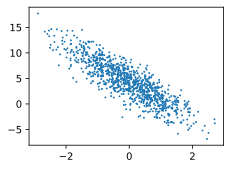

In [5]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1)

In [6]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [7]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break


tensor([[-0.9244, -1.3661],
        [ 0.2472,  0.1824],
        [ 0.6240, -1.4402],
        [ 0.0937, -1.2833],
        [-2.1371,  0.0357],
        [-0.0867, -0.2654],
        [ 1.2605, -0.2183],
        [ 1.1920, -0.0551],
        [-1.4604, -1.2050],
        [-1.0033, -0.9795]]) 
 tensor([[ 6.9894],
        [ 4.0644],
        [10.3311],
        [ 8.7433],
        [-0.1883],
        [ 4.9248],
        [ 7.4494],
        [ 6.7771],
        [ 5.3773],
        [ 5.5217]])


In [17]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [9]:
def linreg(X, w, b):
    """线性回归模型"""
    return torch.matmul(X, w) + b

In [10]:
def squared_loss(y_hat, y): 
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [14]:
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [18]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss
losses = []

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y) # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size) # 使用参数的梯度更新参数
        with torch.no_grad():
            train_l = loss(net(features, w, b), labels)
            # print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')
            losses.append(float(train_l.mean()))

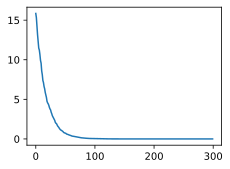

In [19]:
d2l.plt.plot(losses)

In [20]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0002, -0.0004], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0006], grad_fn=<RsubBackward1>)


In [21]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

In [22]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

In [23]:
def load_array(data_arrays, batch_size, is_train=True): #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [29]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [24]:
from torch import nn
net = nn.Sequential(nn.Linear(2, 1))

In [25]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [26]:
loss = nn.MSELoss()

In [27]:
optim = torch.optim.SGD(net.parameters(), lr=0.03)

In [30]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        optim.zero_grad()
        l.backward()
        optim.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')


epoch 1, loss 0.000261
epoch 2, loss 0.000107
epoch 3, loss 0.000106


In [31]:
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)


w的估计误差： tensor([0.0007, 0.0006])
b的估计误差： tensor([-0.0003])
